## Healpix Example notebook

Table: Y3A1_COADD_OBJECT_HPIX with NSIDE *32*, *64*, *1024*, *4098* and *16384*

Function: MCARRAS2.DEGRADE(HPIX,NSIDE) --> HPIX is at NSIDE = 16384. This function downgrades the resolution from nside 16384 to ant other resolution.

HPIX indexes are all in NESTED Schema

In [83]:
%matplotlib inline
import easyaccess as ea
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np

### All objects inside a HPIX at Nside 1024 given a fixed index number

In [2]:
query="""
SELECT s.RA,s.DEC,s.MAG_AUTO_G 
FROM Y3A1_COADD_OBJECT_SUMMARY s, Y3A1_COADD_OBJECT_HPIX t 
WHERE t.COADD_OBJECT_ID=s.COADD_OBJECT_ID 
and t.HPIX_1024 = 4269742;
"""

In [84]:
con=ea.connect()

Connecting to DB ** dessci ** ...


In [4]:
df=con.query_to_pandas(query)

In [5]:
df.tail()

,RA,DEC,MAG_AUTO_G
195,8.543586,-24.534459,24.188610
196,8.561245,-24.571580,99.000000
197,8.556697,-24.540739,21.586061
198,8.544208,-24.542383,24.280333
199,8.560141,-24.554940,24.179508


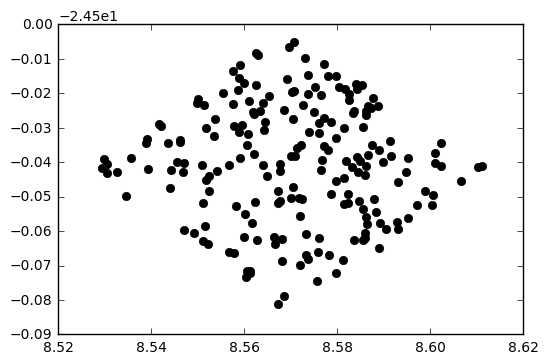

In [6]:
plt.plot(df.RA,df.DEC,'ko')

### Average MAG_AUTO_I and number count for ALL footprint at HPIX 1024 resolution

In [8]:
query="""
SELECT t.HPIX_1024, avg(c.MAG_AUTO_I) MAG_I,count(c.MAG_AUTO_I) COUNT 
FROM Y3A1_COADD_OBJECT_HPIX t, Y3A1_COADD_OBJECT_SUMMARY c 
WHERE t.COADD_OBJECT_ID=c.COADD_OBJECT_ID
GROUP by t.hpix_1024;
"""

In [9]:
df2=con.query_to_pandas(query)

### 1.6M pixels at HPIX 1024

In [10]:
df2.tail()

,HPIX_1024,MAG_I,COUNT
1606302,4489610,28.194397,14
1606303,10129942,20.733717,8
1606304,8498250,21.810465,14
1606305,3914,47.663212,3
1606306,4802187,99.000000,1


In [19]:
NSIDE = 1024
m = np.zeros(hp.nside2npix(NSIDE))+hp.UNSEEN
m[df2.HPIX_1024]=df2.COUNT

### Ploting count numbers

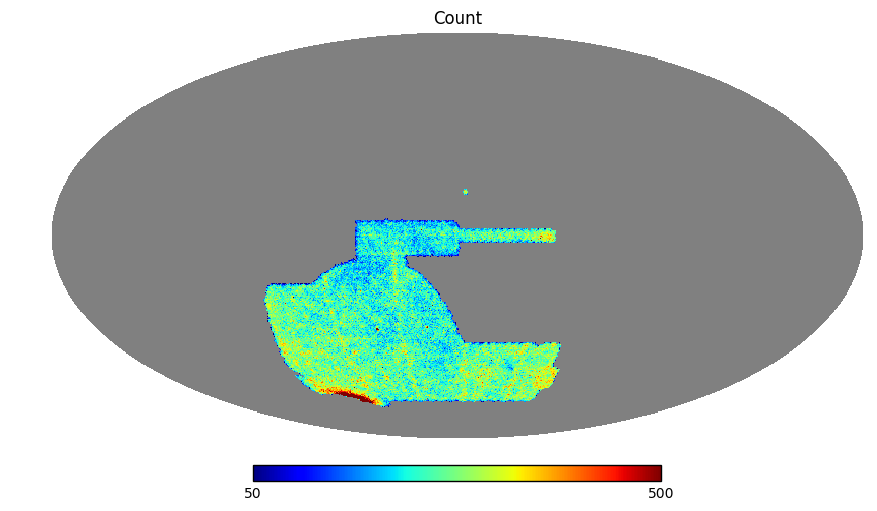

In [20]:
hp.mollview(m, nest=True, title="Count",max=500,min=50)

### Average MAG_AUTO_I and number count for ALL footprint at HPIX 1024 resolution

In [14]:
query="""
SELECT t.HPIX_64, avg(c.MAG_AUTO_I) MAG_I,count(c.MAG_AUTO_I) COUNT 
FROM Y3A1_COADD_OBJECT_HPIX t, Y3A1_COADD_OBJECT_SUMMARY c 
WHERE t.COADD_OBJECT_ID=c.COADD_OBJECT_ID
GROUP by t.hpix_64;
"""

In [15]:
df3=con.query_to_pandas(query)

In [17]:
df3.tail()

,HPIX_64,MAG_I,COUNT
6690,17945,22.872829,54876
6691,16656,22.795364,54134
6692,36760,22.706156,49582
6693,33581,22.956221,62083
6694,17263,27.966591,790


#### 6694 pixels

In [22]:
NSIDE = 64
m = np.zeros(hp.nside2npix(NSIDE))+hp.UNSEEN
m[df3.HPIX_64]=df3.COUNT

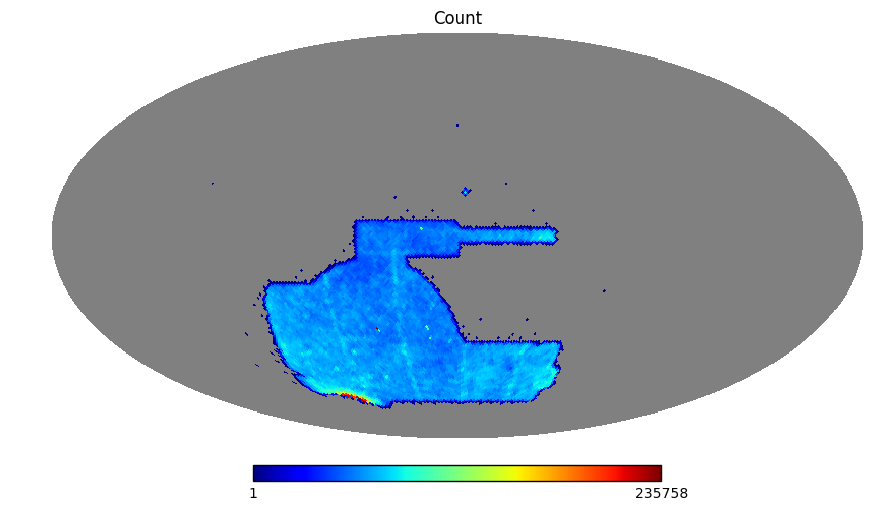

In [23]:
hp.mollview(m, nest=True, title="Count")

### Getting the closes object to a given position

In [57]:
ra=10.
dec=-30.
hpix=hp.ang2pix(16384,(90.-dec)/180.*np.pi,(ra/180.*np.pi),nest=True)

In [80]:
query="""
SELECT RA,DEC,power((s.RA-10.),2) + power((s.DEC+30.),2) as dist,s.COADD_OBJECT_ID from Y3A1_COADD_OBJECT_SUMMARY s, Y3A1_COADD_OBJECT_HPIX t  where t.HPIX_16384 = {}
 and t.COADD_OBJECT_ID=s.COADD_OBJECT_ID and rownum <=1 ORDER BY DIST """

In [81]:
near=con.query_to_pandas(query.format(hpix))

In [82]:
near

,RA,DEC,DIST,COADD_OBJECT_ID
0,10.00024,-30.000981,0.000001,157023983


### Degrade function
Given the hierarchical nature of the Nested scheme we can access lower resolution maps using a simple bit-wise operations, for this I've created a SQL Function called MCARRAS2.DEGRADE(HPIX,NSIDE) which downgrades
the index for a pixel in Nside = 16384 resolution to the given nside resolution,

This query reteieves the hpix for a list of objects, including a 256 nside which is not included in the HPIX table

In [90]:
query="""
SELECT s.COADD_OBJECT_ID,s.RA,s.DEC,t.HPIX_64,MCARRAS2.DEGRADE(t.HPIX_16384,64) H64,MCARRAS2.DEGRADE(t.HPIX_16384,256) H256 
FROM Y3A1_COADD_OBJECT_SUMMARY s, Y3A1_COADD_OBJECT_HPIX t 
WHERE 
t.COADD_OBJECT_ID=s.COADD_OBJECT_ID and 
rownum < 10
"""

In [91]:
temp=con.query_to_pandas(query)

In [92]:
temp

,COADD_OBJECT_ID,RA,DEC,HPIX_64,H64,H256
0,149698747,8.589808,-27.101377,16672,16672,266752
1,149705554,8.594298,-27.235943,16650,16650,266410
2,149706505,8.600120,-27.252970,16650,16650,266410
3,148672863,7.601456,-63.623349,34821,34821,557144
4,148673767,8.171681,-63.638605,34821,34821,557144
5,148677466,7.503361,-63.703449,34820,34820,557133
6,148679446,8.180222,-63.734337,34821,34821,557138
7,157329733,10.178751,-0.297661,18068,18068,289101
8,157326447,10.260372,-0.228683,18069,18069,289112
